In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [4]:
df= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BMI_Data.csv")


**Clustering**

In [5]:
#Keep only columns we need
df = df.copy()

# Fix numeric columns if they were read as text
for col in ["BMI_Value", "CI_Low", "CI_High", "Year"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Create CI range feature
df["CI_Range"] = df["CI_High"] - df["CI_Low"]

# Drop rows missing key features
df_k = df.dropna(subset=["Year", "BMI_Value", "CI_Range", "CountryCode", "Region"])

In [6]:
features = df_k[["BMI_Value", "CI_Range"]].dropna()

In [7]:
adults = df_k.copy()

In [8]:
latest_year = int(adults["Year"].max())
latest = adults[adults["Year"] == latest_year].copy()

# Features for clustering (simple + explainable)
X = latest[["BMI_Value", "CI_Range"]].dropna()

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans (3 groups = Low / Medium / High risk)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Attach results back
latest.loc[X.index, "Cluster"] = labels


In [9]:
# Compute mean BMI per cluster and rank them
cluster_order = (
    latest.groupby("Cluster")["BMI_Value"]
    .mean()
    .sort_values()
    .index.tolist()
)

risk_names = {cluster_order[0]: "Low Risk",
              cluster_order[1]: "Medium Risk",
              cluster_order[2]: "High Risk"}

latest["Risk_Group"] = latest["Cluster"].map(risk_names)

# See sample output
latest[["Year","Region","CountryCode","Sex","BMI_Value","CI_Range","Risk_Group"]].head(10)


,Year,Region,CountryCode,Sex,BMI_Value,CI_Range,Risk_Group
18,2022,Africa,RWA,SEX_BTSX,10.1,4.3,Low Risk
27,2022,Africa,GIN,SEX_BTSX,10.1,7.8,Low Risk
76,2022,Americas,HTI,SEX_FMLE,10.1,7.4,Low Risk
92,2022,Eastern Mediterranean,YEM,SEX_MLE,10.1,9.8,Low Risk
127,2022,Western Pacific,PHL,SEX_FMLE,10.1,6.6,Low Risk
136,2022,Western Pacific,LAO,SEX_FMLE,10.1,8.0,Low Risk
163,2022,Africa,GNB,SEX_MLE,10.2,17.8,Medium Risk
211,2022,Africa,NAM,SEX_MLE,10.2,10.9,Low Risk
215,2022,Africa,SEN,SEX_BTSX,10.2,4.6,Low Risk
258,2022,South-East Asia,NPL,SEX_FMLE,10.2,4.9,Low Risk


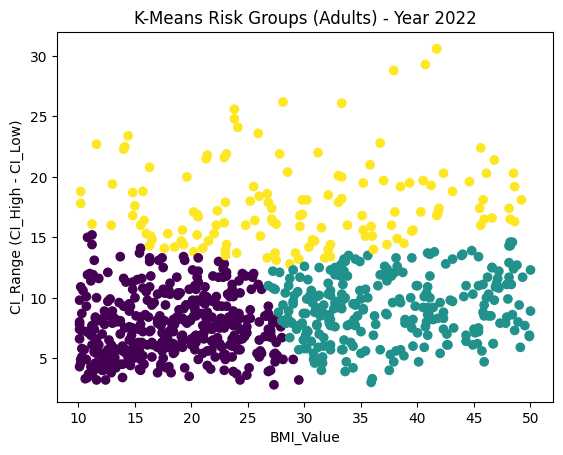

In [10]:
plt.scatter(latest["BMI_Value"], latest["CI_Range"], c=latest["Cluster"])
plt.xlabel("BMI_Value")
plt.ylabel("CI_Range (CI_High - CI_Low)")
plt.title(f"K-Means Risk Groups (Adults) - Year {latest_year}")
plt.show()


**Trend Analysis**

In [11]:
adults["BMI_Value"].describe()


,BMI_Value
count,28017.000000
mean,24.660281
std,11.519153
min,10.100000
25%,15.100000
50%,21.100000
75%,32.800000
max,50.000000


In [12]:
adults.groupby("Sex")["BMI_Value"].agg(["count","mean","median","std","min","max"]).sort_values("mean", ascending=False)


,count,mean,median,std,min,max
Sex,,,,,,
SEX_FMLE,9812,26.292988,23.5,11.803689,10.1,50.0
SEX_BTSX,9499,24.512359,21.0,11.479129,10.1,50.0
SEX_MLE,8706,22.981553,19.3,10.972664,10.1,50.0


In [13]:
adults.groupby("Region")["BMI_Value"].mean().sort_values(ascending=False).head(15)


,BMI_Value
Region,
Americas,27.826044
Western Pacific,27.275777
Europe,26.756689
Eastern Mediterranean,26.000990
South-East Asia,21.986884
Africa,20.030900


In [14]:
adults.groupby("Region")["BMI_Value"].mean().sort_values(ascending=False).head(15)


,BMI_Value
Region,
Americas,27.826044
Western Pacific,27.275777
Europe,26.756689
Eastern Mediterranean,26.000990
South-East Asia,21.986884
Africa,20.030900


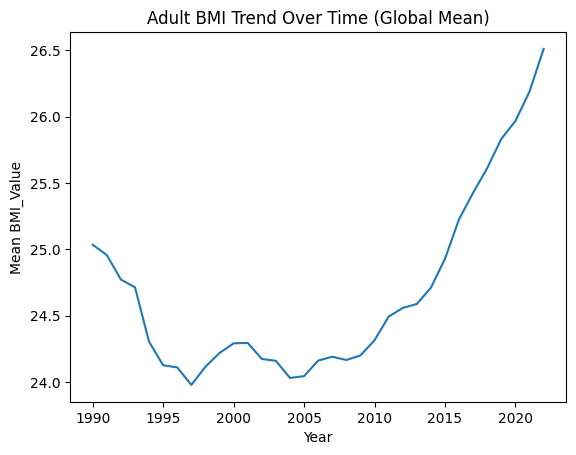

In [15]:
yearly = adults.groupby("Year")["BMI_Value"].mean().reset_index()

plt.plot(yearly["Year"], yearly["BMI_Value"])
plt.xlabel("Year")
plt.ylabel("Mean BMI_Value")
plt.title("Adult BMI Trend Over Time (Global Mean)")
plt.show()


In [16]:
from scipy.stats import ttest_ind

male = adults.loc[adults["Sex"].str.contains("male", case=False, na=False), "BMI_Value"].dropna()
female = adults.loc[adults["Sex"].str.contains("female", case=False, na=False), "BMI_Value"].dropna()

t_stat, p_val = ttest_ind(male, female, equal_var=False)  # Welch's t-test
print("Welch t-test (Male vs Female)")
print("t =", t_stat)
print("p =", p_val)


Welch t-test (Male vs Female)
t = nan
p = nan


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [17]:
#Separating datasets by indicators
df["Indicator"].value_counts()

,count
Indicator,
NCD_BMI_30A,13034
NCD_BMI_25A,11147
NCD_BMI_18A,5737


In [18]:
adult_df = df[df["Indicator"] == "NCD_BMI_25A"]

print("Adult records:", adult_df.shape)

Adult records: (11147, 27)


In [21]:
#Detecting anomalies by region
def detect_anomalies(data, contamination=0.03):

    #Selecting numerical features for anomaly detection
    features = data[['BMI_Value', 'Year', 'CI_Low', 'CI_High']].dropna()

    #Scaling features in the same scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    #Model Isolation Forest
    model = IsolationForest(
        n_estimators=200,
        contamination=contamination,
        random_state=42
    )

    #Training the model
    model.fit(X_scaled)

    #Generating predictions
    anomaly_labels = model.predict(X_scaled)

    #Saving results in the original dataframe
    data = data.loc[features.index].copy()
    data["Anomaly"] = anomaly_labels

    return data


In [24]:
#Making analysis for anomalies by region in ADULTS
adult_results = detect_anomalies(adult_df)

adult_anomalies = adult_results[adult_results["Anomaly"] == -1]

print("Adult anomalies detected:", adult_anomalies.shape[0])

Adult anomalies detected: 335


In [26]:
#Making a ranking of anoamlies by region in ADULTS
adult_region_ranking = adult_anomalies.groupby("Region").size().sort_values(ascending=False)

print("Regions with most Adult BMI anomalies:")
print(adult_region_ranking)

Regions with most Adult BMI anomalies:
Region
Africa                   143
Americas                  51
South-East Asia           42
Europe                    37
Eastern Mediterranean     31
Western Pacific           15
dtype: int64


In [27]:
#Top anomalous countries in ADULTS
adult_country_ranking = (
    adult_anomalies.groupby("CountryCode")["BMI_Value"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

print("Top 10 Critical Countries (Adults):")
print(adult_country_ranking)

Top 10 Critical Countries (Adults):
CountryCode
MUS    50.00
IRL    50.00
ESP    49.90
BLR    49.90
KNA    49.90
MDV    49.90
TTO    49.90
PRI    49.90
PAK    49.90
FIN    49.85
Name: BMI_Value, dtype: float64


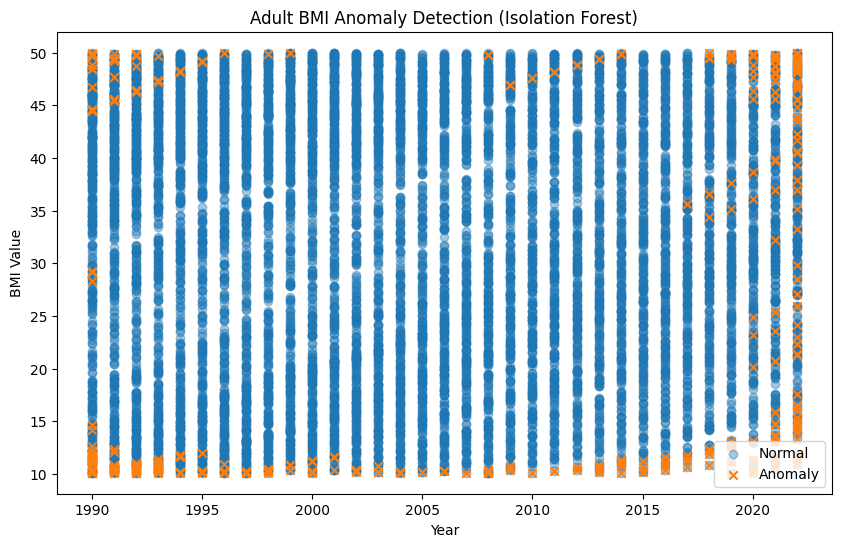

In [28]:
#Visualization of anomalies in ADULTS
plt.figure(figsize=(10,6))

plt.scatter(adult_results["Year"], adult_results["BMI_Value"],
            alpha=0.4, label="Normal")

plt.scatter(adult_anomalies["Year"], adult_anomalies["BMI_Value"],
            marker="x", label="Anomaly")

plt.title("Adult BMI Anomaly Detection (Isolation Forest)")
plt.xlabel("Year")
plt.ylabel("BMI Value")
plt.legend()
plt.show()

This graph shows the results of the Isolation Forest model applied to adult BMI data from 1990 to 2022. Most BMI values follow a consistent global pattern over time, while the highlighted anomaly points represent unusually high or low BMI observations. These outliers may indicate countries or years with abnormal obesity trends or potential health risks that require further investigation.